# 机器学习加权

In [69]:
import pandas as pd
df = pd.read_csv('../data/factors.csv')
df = df.dropna(axis=0)
X = df[['pb','MA20_deviation','ATR_ratio','log_total_mv']]
Y = df[['return_1d','return_5d','return_10d']]

In [ ]:
#标准化数据
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# 标准化因子暴露（保持量纲一致）
scaler = StandardScaler()
factors = ['pb', 'MA20_deviation', 'ATR_ratio', 'log_total_mv']
X = scaler.fit_transform(df[factors])

# 目标收益率（5日收益率）
y = df['return_5d'].values

检查共线性

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print("VIF值:", dict(zip(factors, vif)))  # >10表示严重共线性

VIF值: {'pb': 1.1803964054950162, 'MA20_deviation': 1.0438241351797028, 'ATR_ratio': 1.1498163274593738, 'log_total_mv': 1.1075826704448357}


## 1.线性回归

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
# 拟合线性回归模型
model_lr = LinearRegression(fit_intercept=True)  # 建议包含截距项
model_lr.fit(X, y)

# 获取因子权重（系数）
weights = model_lr.coef_
intercept = model.intercept_

# 输出结果

print("截距项：", intercept)
print("均方误差：", mse(y, model_lr.predict(X)))
weights = pd.Series(weights,index=factors)
weights

截距项： 0.00889195100262283
均方误差： 0.007643487840979883


pb               -0.006107
MA20_deviation   -0.004546
ATR_ratio         0.011433
log_total_mv     -0.001015
dtype: float64

pb                0.264368
MA20_deviation    0.196794
ATR_ratio         0.494887
log_total_mv      0.043950
dtype: float64


<Axes: >

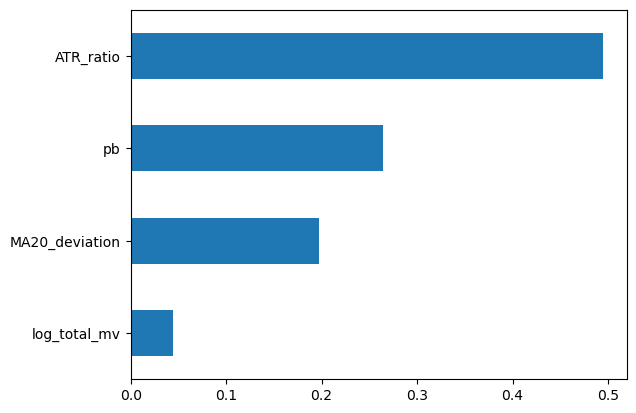

In [114]:
weights = weights.abs() / np.sum(np.abs(weights))  # 归一化权重
# print("因子权重：", dict(zip(factors, weights)))
weights = pd.Series(weights,index=factors)
print(weights)
weights.sort_values().plot(kind='barh')


## 凸优化

pb                0.299990
MA20_deviation    0.233769
ATR_ratio         0.199993
log_total_mv      0.266248
dtype: float64


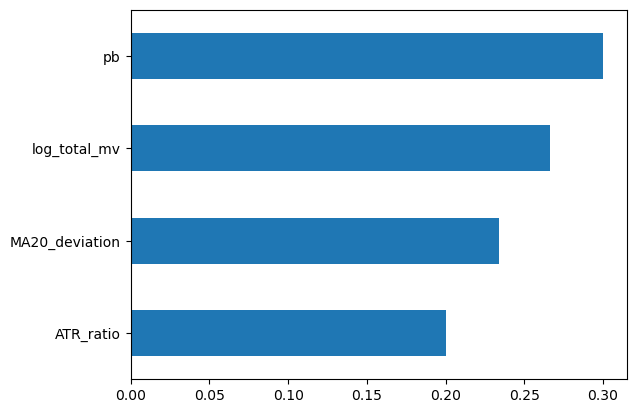

In [ ]:
from cvxpy import *

# 定义优化变量
w = Variable(len(factors))

# 构建约束条件
constraints = [
    sum(w) == 1,                    # 权重和为100%
    w[0] >= 0.3,                     # pb最低权重30%
    w[2] <= 0.2,                     # ATR最高权重20%
    w[3] >= 0,                       # 禁止做空规模因子
    norm(w, 1) <= 1.5                # 控制杠杆率
]

# 最小化预测误差
objective = Minimize(sum_squares(X @ w - y))
prob = Problem(objective, constraints)
prob.solve()

# 获取优化后权重
constrained_weights = np.array(w.value).flatten()
constrained_weights = pd.Series(constrained_weights,index=factors)
print(constrained_weights)
constrained_weights.sort_values().plot(kind='barh')
plt.show()

pb                0.238524
MA20_deviation    0.243521
ATR_ratio         0.258273
log_total_mv      0.259682
Name: XGBoost_Importance, dtype: float32


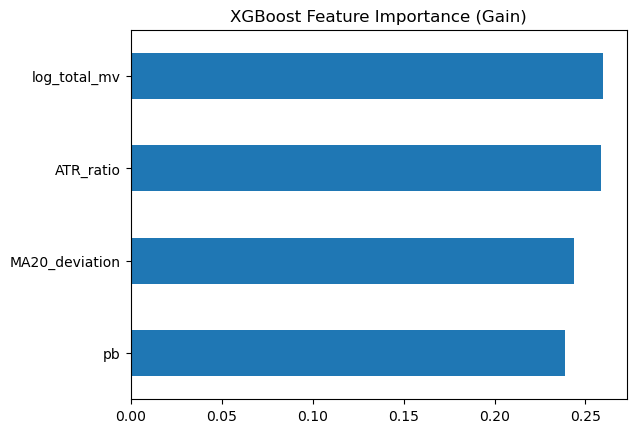

In [106]:
import xgboost as xgb
import matplotlib.pyplot as plt

# 训练模型
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=42)
model_xgb.fit(X, y)

# 获取特征重要性（按'gain'）
importance_xgb = pd.Series(model_xgb.feature_importances_, index=factors, name='XGBoost_Importance')
print(importance_xgb)

# 可视化
importance_xgb.sort_values().plot(kind='barh')
plt.title('XGBoost Feature Importance (Gain)')
plt.show()